In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configurações para os gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

In [3]:
# Carregar a tabela de features v1 (resultado do notebook 02)
path_base = '../data/processed/feature_table_v1.parquet'
df_base = pd.read_parquet(path_base)
print(f"Tabela base carregada com {df_base.shape[0]} registros e {df_base.shape[1]} colunas.")

# Carregar os novos datasets de geração
try:
    path_geracao = '../data/raw/GERACAO_USINA-2_2025_09.csv'
    df_geracao_raw = pd.read_csv(path_geracao, sep=';', decimal=',')
    
    path_fator_cap = '../data/raw/FATOR_CAPACIDADE-2_2025_09.csv'
    df_fator_cap_raw = pd.read_csv(path_fator_cap, sep=';', decimal=',')

    print("Datasets de Geração e Fator de Capacidade carregados.")
except FileNotFoundError as e:
    print(f"ERRO: Arquivo não encontrado - {e}")
    print("Por favor, baixe os arquivos CSV do portal do ONS e coloque-os na pasta /data.")
    raise

Tabela base carregada com 366 registros e 5 colunas.
Datasets de Geração e Fator de Capacidade carregados.


In [6]:
# --- Célula 3: Processamento - Geração por Usina (Versão Corrigida) ---

# Nomes das colunas ajustados com base na sua verificação
coluna_data_geracao = 'din_instante'      # CORRIGIDO
coluna_estado_geracao = 'id_estado'
coluna_tipo_usina = 'nom_tipousina'
coluna_valor_geracao = 'val_geracao'

# Faz uma cópia para evitar warnings
df_geracao = df_geracao_raw[[coluna_data_geracao, coluna_estado_geracao, coluna_tipo_usina, coluna_valor_geracao]].copy()

# Converte data e filtra para Goiás
df_geracao['timestamp'] = pd.to_datetime(df_geracao[coluna_data_geracao])
df_geracao_go = df_geracao[df_geracao[coluna_estado_geracao] == 'GO'].copy()
df_geracao_go.set_index('timestamp', inplace=True)

# 1. Feature: Geração Total Diária
geracao_total_diaria = df_geracao_go[coluna_valor_geracao].resample('D').sum().to_frame(name='geracao_total_diaria_go')

# 2. Features: Geração por Tipo de Usina
# Usa pivot_table para transformar os tipos de usina em colunas
geracao_por_tipo = df_geracao_go.pivot_table(
    values=coluna_valor_geracao,
    index=df_geracao_go.index,
    columns=coluna_tipo_usina,
    aggfunc='sum'
)
# Agrega os valores horários por dia
geracao_por_tipo_diaria = geracao_por_tipo.resample('D').sum()
# Renomeia as colunas para clareza
geracao_por_tipo_diaria.columns = ['geracao_' + col.lower().replace(' ', '_') + '_diaria' for col in geracao_por_tipo_diaria.columns]


print("Features de Geração Total e por Tipo foram criadas.")
display(geracao_total_diaria.head())
display(geracao_por_tipo_diaria.head())

Features de Geração Total e por Tipo foram criadas.


,geracao_total_diaria_go
timestamp,
2025-09-01,0E-80E-844.5000000014.0000000018.00000000363.0...
2025-09-02,0E-80E-818.00000000722.2080000044.50000000519....
2025-09-03,0E-80E-844.50000000131.5650000017.8650000018.0...
2025-09-04,0E-80E-80E-818.0000000014.0000000015.351000004...
2025-09-05,0E-80E-827.4750000044.50000000137.936000005.00...


,geracao_fotovoltaica_diaria,geracao_hidroelétrica_diaria,geracao_térmica_diaria
timestamp,,,
2025-09-01,0E-80E-80E-80E-80E-80E-80E-80E-80E-80E-80E-80E...,44.5000000014.0000000018.00000000363.020000005...,0E-877.7010000016.8250000046.51400000173.50500...
2025-09-02,0E-80E-80E-80E-80E-80E-80E-80E-80E-80E-80E-80E...,18.00000000722.2080000044.50000000519.42300000...,0E-8158.1210000018.5630000056.241000000E-897.0...
2025-09-03,0E-80E-80E-80E-80E-80E-80E-80E-80E-80E-80E-80E...,44.50000000131.5650000017.8650000018.000000000...,97.001000000E-8152.7230000060.7340000053.80000...
2025-09-04,0E-80E-80E-80E-80E-80E-80E-80E-80E-80E-80.2000...,0E-818.0000000014.0000000015.3510000044.500000...,46.799000007.07500000178.6990000077.7640000058...
2025-09-05,0E-80E-80E-80E-80E-80E-80E-80E-80E-80E-80.7310...,27.4750000044.50000000137.936000005.0000000060...,0E-846.8870000097.000000000E-859.551000000E-80...


In [7]:
# --- Célula 4 (Parte A): Diagnóstico - Fator de Capacidade ---

print("Nomes exatos das colunas no arquivo de Fator de Capacidade:")
# Imprime a lista de colunas para podermos copiar os nomes corretos
print(df_fator_cap_raw.columns.tolist())

print("\nPrimeiras 5 linhas do arquivo para visualização:")
# Mostra as primeiras linhas para entendermos o que cada coluna significa
display(df_fator_cap_raw.head())

Nomes exatos das colunas no arquivo de Fator de Capacidade:
['id_subsistema', 'nom_subsistema', 'id_estado', 'nom_estado', 'cod_pontoconexao', 'nom_pontoconexao', 'nom_localizacao', 'val_latitudesecoletora', 'val_longitudesecoletora', 'val_latitudepontoconexao', 'val_longitudepontoconexao', 'nom_modalidadeoperacao', 'nom_tipousina', 'nom_usina_conjunto', 'id_ons', 'ceg', 'din_instante', 'val_geracaoprogramada', 'val_geracaoverificada', 'val_capacidadeinstalada', 'val_fatorcapacidade']

Primeiras 5 linhas do arquivo para visualização:


,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_pontoconexao,nom_pontoconexao,nom_localizacao,val_latitudesecoletora,val_longitudesecoletora,val_latitudepontoconexao,...,nom_modalidadeoperacao,nom_tipousina,nom_usina_conjunto,id_ons,ceg,din_instante,val_geracaoprogramada,val_geracaoverificada,val_capacidadeinstalada,val_fatorcapacidade
0,N,Norte,MA,MARANHAO,MAMR--500-A,MIRANDA II500kVA,NaN,-2.727222,-42.596389,-3.566219,...,Conjunto de Usinas,Eólica,Conj. Paulino Neves,CJU_MAPLN,-,2025-09-01 00:00:00,407.50000000,417.60800000,426.00000000,0.98030046948356807511
1,NE,Nordeste,BA,BAHIA,BAIGD-230-B,IGAPORA II - 230 kV (B),Interior,-14.102794,-42.609369,-14.0303,...,Conjunto de Usinas,Eólica,Conj. Araçás,CJU_BAARA,-,2025-09-01 00:00:00,131.00000000,149.48500000,167.70000000,0.89138342277877161598
2,NE,Nordeste,BA,BAHIA,BAUSB-500,U.SOBRADINHO - 500 kV (A),Interior,-9.751812,-41.006198,-9.436083333,...,Conjunto de Usinas,Eólica,Conj. Arizona,CJU_BAARI,-,2025-09-01 00:00:00,205.50000000,199.57500000,246.01500000,0.81123102249862813243
3,NE,Nordeste,BA,BAHIA,BAMPD-230-A,MORRO CHAPEU2 - 230 kV (A),Interior,-10.97,-41.228,-11.7147,...,Conjunto de Usinas,Eólica,Conj. Babilônia,CJU_BABAB,-,2025-09-01 00:00:00,112.00000000,113.95700000,136.50000000,0.83484981684981684981
4,NE,Nordeste,BA,BAHIA,BAOUR-500-A,OUROLANDIA II500kVA,Interior,-11.0172,-41.304,-10.8745,...,Conjunto de Usinas,Eólica,Conj. Babilônia Centro,CJU_BABBC,-,2025-09-01 00:00:00,410.00000000,485.41900000,553.50000000,0.87699909665763324299


In [10]:
# --- Célula 4 (Parte B): Processamento - Fator de Capacidade ---

# Nomes das colunas ajustados com base na sua verificação.
coluna_data_fc = 'din_instante'          # CORRIGIDO
coluna_subsistema_fc = 'nom_subsistema'
coluna_fonte_fc = 'nom_tipousina'         # CORRIGIDO (usamos o tipo de usina para identificar a fonte)
coluna_valor_fc = 'val_fatorcapacidade'

# Copia as colunas necessárias para um novo dataframe
df_fator_cap = df_fator_cap_raw[[coluna_data_fc, coluna_subsistema_fc, coluna_fonte_fc, coluna_valor_fc]].copy()

# Converte data e filtra para o subsistema SECO
df_fator_cap['timestamp'] = pd.to_datetime(df_fator_cap[coluna_data_fc])
# O subsistema na tabela de interrupção é 'SE', aqui provavelmente é 'SE/CO'. Vamos padronizar para 'SECO' se necessário.
# Neste caso, o filtro por 'SE/CO' deve funcionar se o nome for consistente.
df_fator_cap_seco = df_fator_cap[df_fator_cap[coluna_subsistema_fc] == 'SE/CO'].copy()
df_fator_cap_seco.set_index('timestamp', inplace=True)

# Cria features de fator de capacidade médio por dia para Solar
# Filtra apenas para a fonte 'SOLAR'
# ATENÇÃO: Verifique na amostra se o valor é 'SOLAR' ou 'FOTOVOLTAICA' e ajuste se necessário.
df_fc_solar = df_fator_cap_seco[df_fator_cap_seco[coluna_fonte_fc].str.upper() == 'SOLAR'].copy()

# Calcula a média diária do fator de capacidade
fator_cap_solar_diario = df_fc_solar[coluna_valor_fc].resample('D').mean().to_frame(name='fator_cap_solar_medio_seco')

print("Feature de Fator de Capacidade Solar foi criada.")
display(fator_cap_solar_diario.head())

Feature de Fator de Capacidade Solar foi criada.


,fator_cap_solar_medio_seco
timestamp,


In [11]:
# --- Célula 5: Junção (Merge) de Todas as Features ---

# Começa com a tabela base do notebook anterior
df_combinado = df_base.copy()

# Adiciona as novas features, uma por uma
df_combinado = df_combinado.join(geracao_total_diaria)
df_combinado = df_combinado.join(geracao_por_tipo_diaria)
df_combinado = df_combinado.join(fator_cap_solar_diario)

# Preencher valores nulos que possam surgir da junção (ex: dias sem um certo tipo de geração)
# É uma boa prática preencher com 0 para valores de geração e fator de capacidade.
df_combinado.fillna(0, inplace=True)

print("Tabela final combinada (Alvo + Carga + Geração):")
display(df_combinado.head())

Tabela final combinada (Alvo + Carga + Geração):


/tmp/ipykernel_35078/1490361844.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_combinado.fillna(0, inplace=True)


,deficit_diario_mwh,nivel_risco,programada,verificada,diferenca_verif_prog,geracao_total_diaria_go,geracao_fotovoltaica_diaria,geracao_hidroelétrica_diaria,geracao_térmica_diaria,fator_cap_solar_medio_seco
timestamp,,,,,,,,,,
2023-01-01,0.000000,baixo,55880.9712,59600.4950,3719.5238,0,0,0,0,0
2023-01-02,0.266667,baixo,75755.3677,85261.9366,9506.5689,0,0,0,0,0
2023-01-03,0.000000,baixo,77425.5065,87493.3420,10067.8355,0,0,0,0,0
2023-01-04,0.000000,baixo,79302.0107,86838.6479,7536.6372,0,0,0,0,0
2023-01-05,0.000000,baixo,79123.4357,83777.6296,4654.1939,0,0,0,0,0


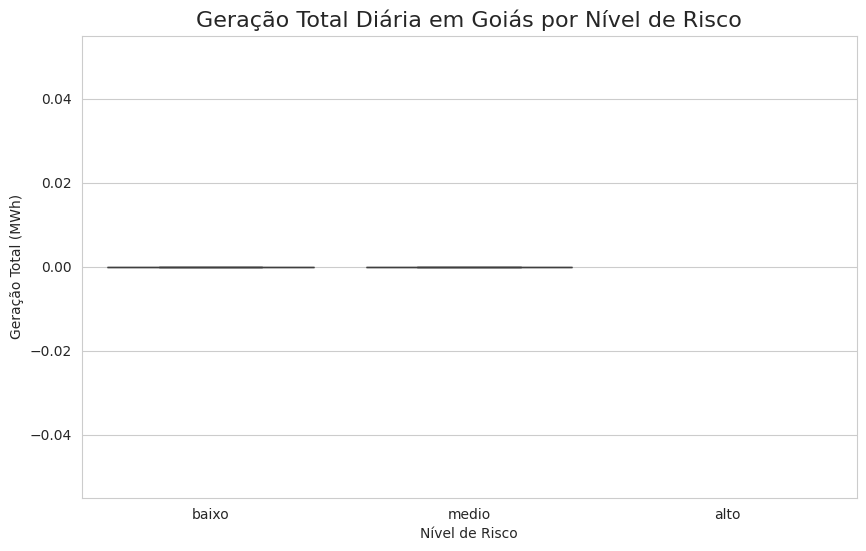

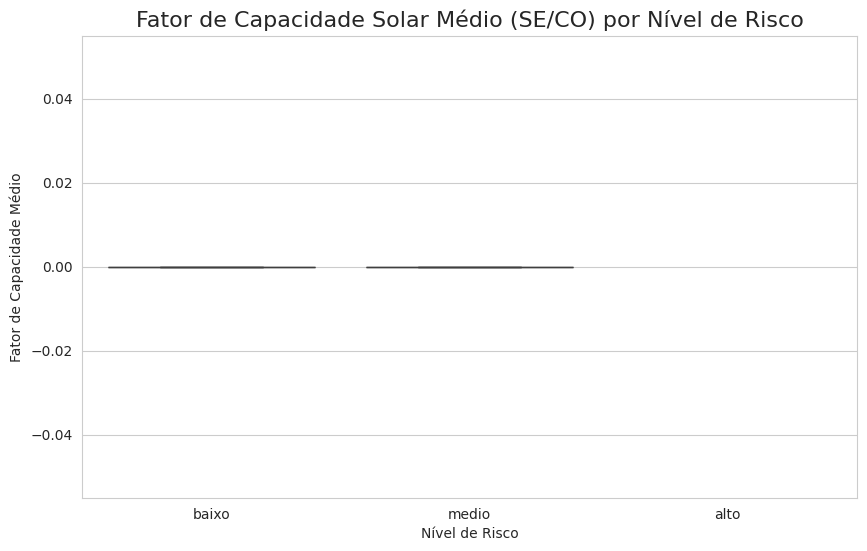

In [12]:
# --- Célula 6: Análise Combinada (Visualizações) ---

# Gráfico 1: Geração Total Diária por Nível de Risco
plt.figure(figsize=(10, 6))
sns.boxplot(x='nivel_risco', y='geracao_total_diaria_go', data=df_combinado, order=['baixo', 'medio', 'alto'])
plt.title('Geração Total Diária em Goiás por Nível de Risco', fontsize=16)
plt.ylabel('Geração Total (MWh)')
plt.xlabel('Nível de Risco')
plt.show()

# Gráfico 2: Fator de Capacidade Solar por Nível de Risco
plt.figure(figsize=(10, 6))
sns.boxplot(x='nivel_risco', y='fator_cap_solar_medio_seco', data=df_combinado, order=['baixo', 'medio', 'alto'])
plt.title('Fator de Capacidade Solar Médio (SE/CO) por Nível de Risco', fontsize=16)
plt.ylabel('Fator de Capacidade Médio')
plt.xlabel('Nível de Risco')
plt.show()